In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Instructions: You can just run all these cells

# Download Famous Paintings

In [ ]:
import requests
import os
import matplotlib.pyplot as plt
import csv
from PIL import Image
from io import BytesIO

url = 'https://collectionapi.metmuseum.org/public/collection/v1/search?medium=Paintings&isHighlight=true&hasImages=true&q=painting'
# url = 'https://collectionapi.metmuseum.org/public/collection/v1/search?medium=Paintings&isHighlight=true&hasImages=true&q=modern'
response = requests.get(url).json()
print(response)
object_ids = response.get('objectIDs')
print(object_ids)

{'total': 518, 'objectIDs': [456949, 733808, 544502, 250939, 435641, 436573, 437769, 436440, 437900, 438814, 16255, 247009, 437326, 437971, 435853, 437455, 437609, 436323, 437891, 435851, 436851, 437447, 439933, 247008, 74813, 656430, 50486, 437329, 437826, 437549, 435728, 438754, 436964, 436840, 438605, 437175, 437879, 436658, 437423, 436918, 437869, 436105, 436106, 436792, 435802, 437056, 679844, 438815, 436575, 634108, 436603, 437532, 435621, 436244, 435809, 436838, 488486, 487695, 40055, 488978, 669451, 436944, 459119, 37801, 435962, 459107, 436545, 488732, 437654, 435702, 493210, 459007, 500194, 435882, 437127, 437658, 436095, 437053, 489307, 435908, 437344, 459052, 436579, 436947, 436504, 435739, 436121, 701989, 440723, 435888, 458994, 437835, 436516, 437133, 436101, 437926, 459088, 437854, 438820, 485901, 437261, 436002, 459087, 435984, 458978, 459142, 459082, 459016, 437097, 437487, 437490, 438817, 626692, 459093, 459080, 459123, 492697, 438816, 459136, 437430, 437131, 437397, 

In [ ]:
# Setup folders/files
save_dir = '/content/drive/MyDrive/1430_final_proj'
os.makedirs(save_dir, exist_ok=True)
image_dir = os.path.join(save_dir, 'images')
embedding_dir = os.path.join(save_dir, 'embeddings')
os.makedirs(image_dir, exist_ok=True)
os.makedirs(embedding_dir, exist_ok=True)
csv_file_path = os.path.join(save_dir, 'data_info.csv')
print(csv_file_path)

/content/drive/MyDrive/1430_final_proj/data_info.csv


In [ ]:
# Setup CLIP
import requests
import torch
from transformers import AutoProcessor, AutoTokenizer, CLIPModel
from PIL import Image

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
inputs = processor(images=image, return_tensors="pt")
image_features = model.get_image_features(**inputs)
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
inputs = tokenizer(["a photo of a cat", "a photo of a dog"], padding=True, return_tensors="pt")
text_features = model.get_text_features(**inputs)

In [ ]:
def create_image_embedding(image):
    # Expect PIL image
    inputs = processor(images=image, return_tensors="pt")
    image_features = model.get_image_features(**inputs)
    return image_features

def create_dataset():
    # Setup CSV file
    with open(csv_file_path, 'w', newline='', encoding='utf-8') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Image Path', 'Title', 'Artist', 'Date', 'Medium', 'Embedding Path'])
        worked = 0

        for object_id in object_ids:
            print(object_id)
            try:
                # Fetch object details
                object_url = f'https://collectionapi.metmuseum.org/public/collection/v1/objects/{object_id}'
                object_response = requests.get(object_url)
                object_details = object_response.json()

                # Extract details
                title = object_details.get('title', 'Unknown Title')
                artist = object_details.get('artistDisplayName', 'Unknown Artist')
                date = object_details.get('objectDate', 'Unknown Date')
                medium = object_details.get('medium', 'Unknown Medium')
                image_url = object_details.get('primaryImage')

                # Skip if no image
                if not image_url:
                    continue

                # Download image
                image_response = requests.get(image_url)

                # Check if image download was successful
                if image_response.status_code == 200:
                    name = f"{artist.replace(' ', '_')}_{title.replace(' ', '_')}"
                    image_save_path = os.path.join(image_dir, name + '.jpg')
                    with open(image_save_path, "wb") as file:
                        file.write(image_response.content)

                    # Create and save image embedding
                    image_embedding = create_image_embedding(Image.open(BytesIO(image_response.content)))
                    embedding_save_path = os.path.join(embedding_dir, name + '.pt')
                    torch.save(image_embedding, embedding_save_path)

                    csv_writer.writerow([image_save_path, title, artist, date, medium, embedding_save_path])

                    # image = Image.open(save_path)
                    # plt.figure(figsize=(10, 10))
                    # plt.imshow(image)
                    # plt.axis("off")
                    # plt.title(f"{title} by {artist}")
                    # plt.tight_layout()
                    # plt.show()

                    worked += 1

            except Exception as e:
                print(f"Object id = {object_id} broke: {e}")

    print('Num working:', worked)

In [ ]:
create_dataset()

456949
733808
544502
250939
435641
436573
437769
436440
437900
438814
16255
247009
437326
437971
435853
437455
437609
436323
437891
435851
436851
437447
439933
247008
74813
656430
50486
437329
437826
437549
435728
438754
436964
436840
438605
437175
437879
436658
437423
436918
437869
436105
436106
436792
435802
437056
679844
438815
436575
634108
436603
437532
435621
436244
435809
436838
488486
487695
40055
488978
669451
436944
459119
37801
435962
459107
436545
488732
437654
435702
493210
459007
500194
435882
437127
437658
436095
437053
489307
435908
437344
459052
436579
436947
436504
435739
436121
701989
440723
435888
458994
437835
436516
437133
436101
437926
459088
437854
438820
485901
437261
436002
459087
435984
458978
459142
459082
459016
437097
437487
437490
438817
626692
459093
459080
459123
492697
438816
459136
437430
437131
437397
749639
458967
435844
435896
435817
437394
436532
459046
436622
458977
437675
438818
815112
437881
676458
500488
435876
37971
436528
459139
435826
43625

In [ ]:
import pandas as pd

df = pd.read_csv(csv_file_path)
print(df.head())
print(df.info())

                                          Image Path  \
0  /content/drive/MyDrive/1430_final_proj/images/...   
1  /content/drive/MyDrive/1430_final_proj/images/...   
2  /content/drive/MyDrive/1430_final_proj/images/...   
3  /content/drive/MyDrive/1430_final_proj/images/...   
4  /content/drive/MyDrive/1430_final_proj/images/...   

                                               Title  \
0                             Great Indian Fruit Bat   
1  Ceiling painting from the palace of Amenhotep III   
2  Wall painting on black ground: landscape, from...   
3                                  Madonna and Child   
4      Cardinal Fernando Niño de Guevara (1541–1609)   

                                Artist                                Date  \
0                          Bhawani Das                         ca. 1777–82   
1                                  NaN                  ca. 1390–1352 B.C.   
2                                  NaN  last decade of the 1st century BCE   
3             

In [ ]:
for _, row in df.iloc[:100].iterrows():
    image_path, title, artist, date, medium = row['Image Path'], row['Title'], row['Artist'], row['Date'], row['Medium']
    img = Image.open(image_path)
    plt.imshow(img)
    plt.show()
    print(f'Title: {title} \nArtist: {artist} \nDate: {date} \nMedium: {medium}')

# Lookup

In [ ]:
import pandas as pd

df = pd.read_csv(csv_file_path)
all_embeddings = []
for _, row in df.iloc[:].iterrows():
    image_path, title, artist, date, medium, embedding_path = row['Image Path'], row['Title'], row['Artist'], row['Date'], row['Medium'], row['Embedding Path']
    embedding = torch.load(embedding_path)
    all_embeddings.append(embedding)

# shape torch.Size([379, 512])
all_embeddings = torch.stack(all_embeddings).squeeze(1)

<ipython-input-37-ee42fc251448>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embedding = torch.load(embedding_path)


In [ ]:
def get_text_embedding(text):
    inputs = tokenizer([text], padding=True, return_tensors="pt")
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
    return text_features

def get_k_most_similar_image_paths(text, k):
    # Get text embedding
    text_embedding = get_text_embedding(text)

    # Compute similarity
    text_embedding = text_embedding / text_embedding.norm(dim=-1, keepdim=True)
    all_embeddings_norm = all_embeddings / all_embeddings.norm(dim=-1, keepdim=True)
    similarities = torch.mm(text_embedding, all_embeddings_norm.T)

    # Get top-k indices
    top_k_indices = torch.topk(similarities, k=k, dim=1).indices.squeeze(0).tolist()

    # Retrieve image paths
    top_k_image_paths = df.iloc[top_k_indices]['Image Path'].tolist()

    return top_k_image_paths


Top-k similar image paths: ['/content/drive/MyDrive/1430_final_proj/images/Jean_Honoré_Fragonard_Marie_Emilie_Coignet_de_Courson_(1716–1806)_with_a_Dog.jpg', "/content/drive/MyDrive/1430_final_proj/images/Thomas_Eakins_The_Artist's_Wife_and_His_Setter_Dog.jpg", '/content/drive/MyDrive/1430_final_proj/images/_Lion.jpg', '/content/drive/MyDrive/1430_final_proj/images/Sir_Thomas_Lawrence_Elizabeth_Farren_(born_about_1759,_died_1829),_Later_Countess_of_Derby.jpg', '/content/drive/MyDrive/1430_final_proj/images/Goya_(Francisco_de_Goya_y_Lucientes)_Manuel_Osorio_Manrique_de_Zuñiga_(1784–1792).jpg']


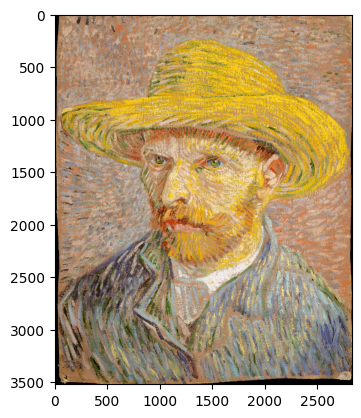

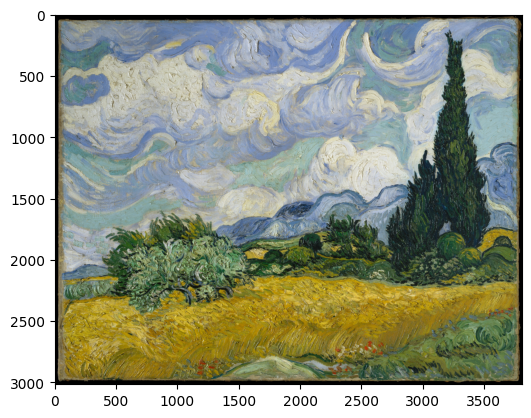

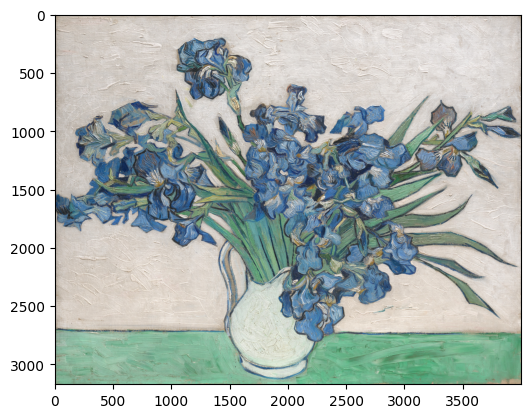

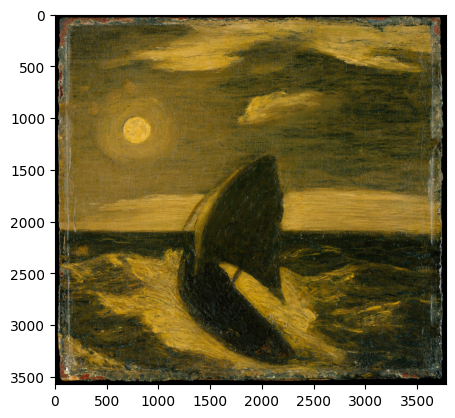

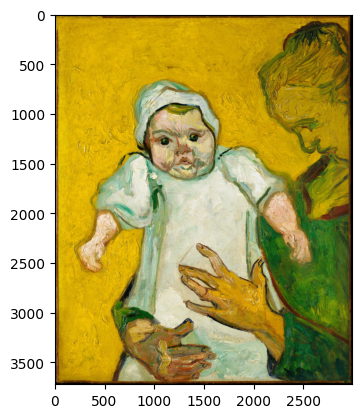

In [ ]:
# Query should be more of a style as opposed to a specific object
text_query = "Image of Van gogh style"
top_k_images = get_k_most_similar_image_paths(text_query, k=5)
for path in top_k_images:
    img = Image.open(path)
    plt.imshow(img)
    plt.show()

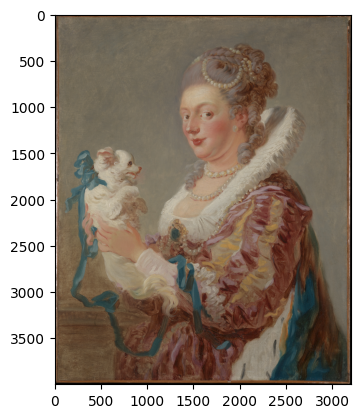

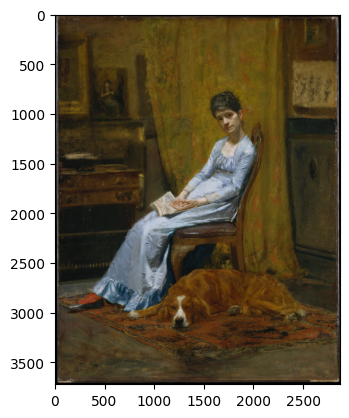

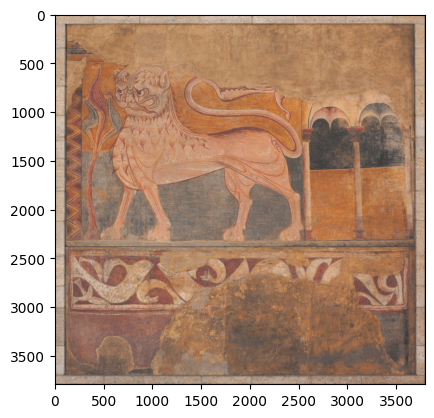

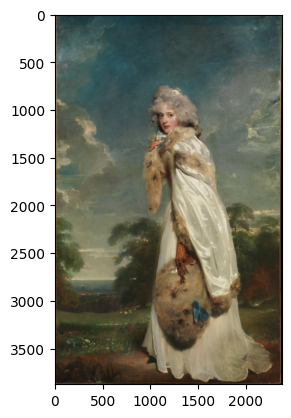

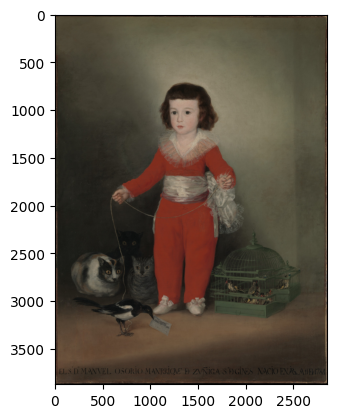

In [ ]:
# Uhh
text_query = "Image of a dog"
top_k_images = get_k_most_similar_image_paths(text_query, k=5)
for path in top_k_images:
    img = Image.open(path)
    plt.imshow(img)
    plt.show()